# Imports...

In [1]:
import tensorflow as tf
import sklearn as sk
from sklearn import model_selection
import numpy as np

import data_loading
import data_visualisation
from model_constructor import ModelConstructor, ModelName

import model_convertor

# Ensure same seed on every run in order to get consistent results

In [2]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(1337)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(5)

# We also specify a random seed for sklearn, used for K-fold cross validation
sklearn_random_seed = 5354

# Some compatibility checks

In [3]:
print(f"TF version: {tf.__version__}")
print(f"Logical devices: {tf.config.list_logical_devices()}")
print(f"TF built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"Visible devices: {tf.config.get_visible_devices()}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

TF version: 2.8.4
Logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
TF built with CUDA: True
Visible devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Specifying our model and training parameters

In [4]:
batch_size = 265
epochs = 768 
curr_model = ModelName.BEERNET_LITE
include_preprocessing_layers = True

# Trying out various input shapes
# input_shape = (100, 3) # For 1D CNN
# input_shape = (100, 3, 1)
# input_shape = (50, 2, 3)
# input_shape = (25, 4, 3)
input_shape = (20, 5, 3)
# input_shape = (10, 10, 3)


print("Input shape:", input_shape)

# Number of classes is the number of gestures, which is the number of output neurons
num_classes = len(data_loading.GestureNames)

model: tf.keras.Model = ModelConstructor.get_model(model=curr_model, input_shape=input_shape, 
                                                   num_classes=num_classes, include_preprocessing=include_preprocessing_layers)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Before K-fold cross validation, store the initial weights of the model, 
# so that we can train the model from scratch on the entire dataset after K-fold cross validation without recompiling the model
initial_weights = model.get_weights()

model.summary()

Input shape: (20, 5, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation (RandomT  (None, 20, 5, 3)         0         
 ranslation)                                                     
                                                                 
 random_contrast (RandomCont  (None, 20, 5, 3)         0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 20, 5, 16)         160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 5, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 4, 32)         2080      
                                

# Load all data that was collected

In [5]:
# This gets all data and puts them into a single dictionary with the following structure:
# {
#     "candidate_id": {
#         "gesture_name": [
#             [sample1],
#             [sample2],
#             ...
#         ],
#         ...
#     },
#     ...
# }


all_data_per_candidate = data_loading.load_gestures_grouped_per_candidate(use_left_hand=True, use_right_hand=True, split_candidate_per_hand=True)
all_candidates = list(all_data_per_candidate.keys())

# Possibly remove unwanted candidates
all_candidates.remove("b2_L")
all_candidates.remove("b2_R")
# all_candidates.remove("b2")

# all_data and all_labels are used for training the final model after K-fold cross validation
all_data, all_labels = data_loading.get_data_and_labels_from_candidates(list(all_data_per_candidate.keys()), all_data_per_candidate, input_shape=input_shape)

# Print all candidates, for checking purposes
print("All candidates:", all_candidates)

# Print length of entire dataset
print("Length of all data:", all_data.shape)

# Plot one sample to check pre-processing
# try:
#     data_visualisation.plot_data_as_image(training_data[0], label=training_labels[0])
#     data_visualisation.plot_data_as_graph(training_data[0], title=training_labels[0])
# except Exception as e:
#     print("Error plotting data as image: ", e)
#     pass

All candidates: ['Arne_L', 'B1_L', 'C2_L', 'C4_L', 'C5_L', 'C8_L', 'C9_L', 'E0_L', 'E1_L', 'E10_L', 'E11_L', 'E12_L', 'E3_L', 'E5_L', 'E7_L', 'sem_15052023_L', 'A0_R', 'A1_R', 'A3_R', 'A4_R', 'A5_R', 'Arne_R', 'B1_R', 'C1_R', 'C3_R', 'C5_R', 'C6_R', 'C9_R', 'E0_R', 'E10_R', 'E11_R', 'E12_R', 'E2_R', 'E3_R', 'E4_R', 'E5_R', 'E6_R', 'E7_R', 'E8_R', 'E9_R', 'sem_15052023_R']
Length of all data: (2314, 20, 5, 3)


# Testing the model using K-Fold Cross Validation

In [6]:
# General training of the model
# model.fit(training_data, training_labels, batch_size=32, epochs=250)
# model.fit(training_data, training_labels, batch_size=64, epochs=500)

# Perform k-fold cross validation
k = min(10, len(all_candidates))

kfold = sk.model_selection.StratifiedKFold(n_splits=k, shuffle=True, random_state=sklearn_random_seed)
kfold_scores = []
confusion_matrices = []
histories = []

all_candidates = np.array(all_candidates)

# Since there is an imbalance in the dataset we make use of stratified k-fold cross validation
# Make a list of labels that correspond to the candidate's used hand. 
# If the candidate used their left hand, the label is 0, otherwise it is 1
# Currently, done by checking if the candidate's name contains "_L", probably not the best way
hand_labels = [0 if "_L" in candidate else 1 for candidate in all_candidates]

print(f"Training model with architecture: {curr_model.name} with {k}-fold cross validation")
left_hand_count = len([label for label in hand_labels if label == 0])
print(f"Using {len(all_candidates)} candidates/hands of which {left_hand_count} used their left hand and {len(all_candidates) - left_hand_count} used their right hand")
print("-----------------------------------")

# Add a callback to stop training early if the validation loss does not improve
# Not using this since number of epochs was treated as a hyperparameter
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

for idx, (train, test) in enumerate(kfold.split(all_candidates, hand_labels)):
    print(f"Fold {idx + 1} of {k}. Training on: {train}, testing on {test}")
    print("Train candidates:", all_candidates[train], "Test candidates:", all_candidates[test])
    
    # Specifying the model and compiling it
    model = ModelConstructor.get_model(model=curr_model, input_shape=input_shape, 
                                       num_classes=num_classes, include_preprocessing=include_preprocessing_layers)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    # When using categorical crossentropy, the labels need to be one-hot encoded instead of just being mapped to integers
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #                 loss=tf.keras.losses.CategoricalCrossentropy(),
    #                 metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    # Getting the training and testing data
    train_features, train_labels = data_loading.get_data_and_labels_from_candidates(all_candidates[train], all_data_per_candidate, input_shape=input_shape)
    test_features, test_labels = data_loading.get_data_and_labels_from_candidates(all_candidates[test], all_data_per_candidate, input_shape=input_shape)

    # Converting the labels to integers, important for the loss function to work
    train_labels = data_loading.map_labels_to_integers(train_labels)
    test_labels = data_loading.map_labels_to_integers(test_labels)

    # Use this when using categorical crossentropy
    # train_labels = data_loading.map_labels_to_one_hot_encoding(train_labels)
    # test_labels = data_loading.map_labels_to_one_hot_encoding(test_labels)

    # Training the model
    # history = model.fit(train_features, train_labels, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping_callback], verbose = 0)
    history = model.fit(train_features, train_labels, batch_size=batch_size, epochs=epochs, verbose=0)

    # Gathering results of this fold
    histories.append(history)
    score = model.evaluate(test_features, test_labels, verbose=0)
    print("Loss and accuracy:", score)
    kfold_scores.append(score)
    confusion_matrices.append(sk.metrics.confusion_matrix(test_labels, np.argmax(model.predict(test_features), axis=1)))

    print("-----------------------------------")


Training model with architecture: BEERNET_LITE with 10-fold cross validation
Using 41 candidates/hands of which 16 used their left hand and 25 used their right hand
-----------------------------------
Fold 1 of 10. Training on: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 24 25 26
 27 28 30 31 32 33 34 35 36 37 38 39], testing on [ 4 15 18 29 40]
Train candidates: ['Arne_L' 'B1_L' 'C2_L' 'C4_L' 'C8_L' 'C9_L' 'E0_L' 'E1_L' 'E10_L' 'E11_L'
 'E12_L' 'E3_L' 'E5_L' 'E7_L' 'A0_R' 'A1_R' 'A4_R' 'A5_R' 'Arne_R' 'B1_R'
 'C1_R' 'C3_R' 'C5_R' 'C6_R' 'C9_R' 'E0_R' 'E11_R' 'E12_R' 'E2_R' 'E3_R'
 'E4_R' 'E5_R' 'E6_R' 'E7_R' 'E8_R' 'E9_R'] Test candidates: ['C5_L' 'sem_15052023_L' 'A3_R' 'E10_R' 'sem_15052023_R']
Loss and accuracy: [2.126030445098877, 0.6716980934143066]
-----------------------------------
Fold 2 of 10. Training on: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26
 27 28 29 30 31 33 34 35 36 37 38 39 40], testing on [ 3  6 25 32]
Train candi

# Printing some of the validation results

Results of model with architecture: BEERNET_LITE with 10-fold cross validation. 
Using 41 candidates of which 16 used their left hand and 25 used their right hand.
K-fold scores: [[2.126030445098877, 0.6716980934143066], [0.7209831476211548, 0.8394495248794556], [0.7445111274719238, 0.8382353186607361], [0.39919841289520264, 0.8666666746139526], [0.7378252744674683, 0.8450704216957092], [2.010899066925049, 0.6741071343421936], [2.0569610595703125, 0.7475728392601013], [1.4783791303634644, 0.7571428418159485], [1.0966620445251465, 0.8067632913589478], [1.9599730968475342, 0.6995074152946472]]
Average k-fold score: [1.33314228 0.77462136]
Std k-fold score: [0.63480327 0.07077674]
1.3331422805786133 ± 0.6348032741502844
0.7746213555335999 ± 0.07077674392862536
Normalised confusion matrix


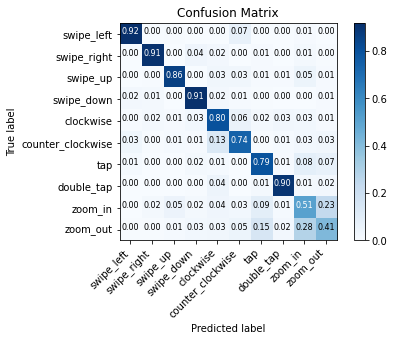

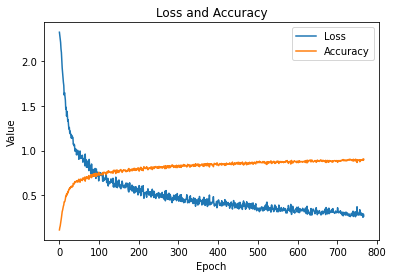

In [7]:
print(f"Results of model with architecture: {curr_model.name} with {k}-fold cross validation. ")
print(f"Using {len(all_candidates)} candidates of which {left_hand_count} used their left hand and {len(all_candidates) - left_hand_count} used their right hand.")
print("K-fold scores:", kfold_scores)
mean_kfold_scores = np.mean(kfold_scores, axis=0)
print("Average k-fold score:", mean_kfold_scores)
print("Std k-fold score:", np.std(kfold_scores, axis=0))

with np.printoptions(precision=5):
    for avg, std in zip(mean_kfold_scores, np.std(kfold_scores, axis=0)):
        # print({"{:.3f}".format(avg)} + "±" + "{:.3f}".format(std))
        print(f"{avg} ± {std}")


# Plot the confusion matrix
confusion_matrix = np.mean(confusion_matrices, axis=0)
data_visualisation.plot_confusion_matrix(confusion_matrix, [gesture.value for gesture in data_loading.GestureNames], normalize=True)

# Plot the training history by averaging the histories over the k-folds
loss = np.mean([history.history['loss'] for history in histories], axis=0)
accuracy = np.mean([history.history['sparse_categorical_accuracy'] for history in histories], axis=0)
# accuracy = np.mean([history.history['categorical_accuracy'] for history in histories], axis=0)
data_visualisation.plot_loss_and_accuracy(loss, accuracy)

# Training the model with the entire dataset

In [8]:
# After K-fold cross validation, reset the weights of the model to the initial weights
model.set_weights(initial_weights)

# And now we can train the model on all the data (training + testing)
all_labels = data_loading.map_labels_to_integers(all_labels)
model.fit(all_data, all_labels, batch_size=batch_size, epochs=epochs, verbose=0)

print("Training on all data finished.")

# Save the model as a .tflite file so that it can be compared to the quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(f"models/{curr_model.name}_epochs_{epochs}_batch_size_{batch_size}_include_preprocessing_{include_preprocessing_layers}.tflite", 'wb') as f:
    f.write(tflite_model)

# history = model.history.history
# Plot the loss and accuracy
# data_visualisation.plot_loss_and_accuracy(history['loss'], history['sparse_categorical_accuracy'])

Training on all data finished.
INFO:tensorflow:Assets written to: C:\Users\arned\AppData\Local\Temp\tmp73eeqss8\assets


In [9]:
%%script false

# This is not needed if we use K-fold cross validation
# To use this define ``testing_data`` and ``testing_labels``.

predictions = model.predict(testing_data)

gesture_classes = list(data_loading.GestureNames)

for i in range(len(predictions)):
    with np.printoptions(precision=6, suppress=True):
        print(f"Actual: {gesture_classes[testing_labels[i]]}, Predicted: {gesture_classes[np.argmax(predictions[i])]}")
        print(f"Confidence of prediction: {np.max(predictions[i])}, All predictions: {predictions[i]}")

    # Plot sample if it is wrong
    if testing_labels[i] != np.argmax(predictions[i]):
        try:
            data_visualisation.plot_data_as_image(testing_data[i], label=f"Predicted: {gesture_classes[np.argmax(predictions[i])]}, Actual: {gesture_classes[testing_labels[i]]}")
            data_visualisation.plot_data_as_graph(testing_data[i], title=f"Predicted: {gesture_classes[np.argmax(predictions[i])]}, Actual: {gesture_classes[testing_labels[i]]}")
        except:
            pass

    print("")


Couldn't find program: 'false'


# Exporting our model for TFLite

In [10]:
model_convertor.quantize_model(model, all_data, write_to_file=True)

print("Model converted to tflite")

INFO:tensorflow:Assets written to: C:\Users\arned\AppData\Local\Temp\tmpldruzyry\assets


INFO:tensorflow:Assets written to: C:\Users\arned\AppData\Local\Temp\tmpldruzyry\assets
c:\Python310\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model converted to tflite


# Validating compressed model

In [11]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()
signature = interpreter.get_signature_runner()

# print("input details:", interpreter.get_input_details())
# print("output details:", interpreter.get_output_details())
# print("input shape:", interpreter.get_input_details()[0]['shape'])

# Get one sample of data to test the model from all the data.
# Use the first sample of data.
# Do note that this sample is used in the training data, so the model has seen this sample before and this is only for verification purposes.
i = 123
sample_data = np.expand_dims(all_data[i], axis=0)
print("Label: ", all_labels[i])
output = signature(sensor_image=sample_data.astype(np.float32))
print("Output:", output)

Label:  4
Output: {'predictions': array([[0.        , 0.        , 0.        , 0.        , 0.99609375,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)}


# Converting the TFLite to C code

Run this command:

```
xxd -i converted_model.tflite > model_data.cpp
```